# Imports

In [1]:
import pandas as pd
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# Model

In [2]:
# Description: The class MyModel describes a multi-layer perceptron with two hidden layers and one output layer. Regularizers and dropout 
#              included
class MyModel(tf.keras.Model):
    
    # Description: Set up layers and define regularizers and dropout
    def __init__(self):
        super(MyModel, self).__init__()
        self.hidden_layer1 = tf.keras.layers.Dense(11, activation=tf.nn.relu, kernel_regularizer=  tf.keras.regularizers.l2(0.001))
        self.dropout = tf.keras.layers.Dropout(0.2)
        self.hidden_layer2 = tf.keras.layers.Dense(11, activation=tf.nn.relu, kernel_regularizer=  tf.keras.regularizers.l2(0.001))
        self.output_layer = tf.keras.layers.Dense(1, activation=tf.nn.sigmoid)
    
    # Description: First a python decorater is called to transform the call function to a computational graph
    #              Then the call function passes the inputs through the layers of the model (forward pass)
    #              @parameters: input, training label
    #              @returns: final_pass
    @tf.function
    def call(self, inputs, training = True):
        x = self.hidden_layer1(inputs)
        x = self.hidden_layer2(x)
        if training:
            x = self.dropout(x, training=training)    
        x = self.output_layer(x)
        return x

# Utility functions

In [3]:
#Description: prepare whole dataframe -> split into train, test and validate, and transform dataframe to tensorflow dataset
#             Inputs: dataframe, threshold
#             Outputs: train_dataset, test_dataset, val_dataset
def prepare_all_data(df_wine, threshold):
    # shuffle dataframe
    df_wine = df_wine.sample(frac=1).reset_index(drop=True)

    # define features and target labels
    features = list(df_wine.columns)[:-1]
    target = "quality"

    # Create a Tensorflow Dataset and a Dataset Pipeline
    ## split data frame into train(60%), test(20%), validation(20%)
    train_df, test_df, val_df = np.split(df_wine.sample(frac=1, random_state=42), [int(0.6*len(df_wine)), int(0.8*len(df_wine))])


    # convert dataframes into tensorflow datasets
    # shuffle, batch, prefetch
    train_dataset = prepare_dataset(train_df, threshold, features, target)
    test_dataset = prepare_dataset(test_df, threshold, features, target)
    val_dataset = prepare_dataset(val_df, threshold, features, target)
    
    return train_dataset, test_dataset, val_dataset

In [4]:
#Description: prepare dataset-> transform dataframe to tensorflow dataset and 
#             quality to binary values and shuffle, batch and prefetch
#             Inputs: dataframe, threshold, features, target
#             Outputs: dataset
def prepare_dataset(dataframe, threshold, features, target):
    # convert dataframes into tensorflow datasets
    dataset = (
        tf.data.Dataset.from_tensor_slices(
            (tf.cast(dataframe[features].values, tf.float32), tf.cast(dataframe[target].values, tf.int32))
        )
    )
    
    # map make_binary() function to dataset
    dataset = dataset.map(lambda inputs, target: (inputs, make_binary(target, threshold)))
  
    # shuffle
    dataset = dataset.shuffle(1599)
    
    # apply batching 
    dataset = dataset.batch(32)

    # prefetch data
    dataset = dataset.prefetch(32)

    #return preprocessed dataset
    return dataset

In [5]:
#Description: Ranks wine into good or bad
#             Inputs: target, a set threshold
#             Outputs: ranked quality of wine (binary value)
def make_binary(target, threshold):
    # wine ranked good
    if target >= tf.constant(threshold, dtype=tf.int32):
        return 1
    # wine ranked bad
    else:
        return 0

In [6]:
#Description: This function trains an object of the class MyModel. It conducts a forward-step and the backpropagation 
#             throughout the network. The optimizer updates weights and biases. 
#             Inputs: model, inputs, target, loss function, optimizer
#             Outputs:loss, accuracy
def train_step(model, inputs, target, loss_function, optimizer):
    # loss_object and optimizer_object are instances of respective tensorflow classes
    with tf.GradientTape() as tape:
        prediction = model(inputs)
        loss = loss_function(target, prediction)
        sample_train_accuracy =  target == np.round(prediction)
        sample_train_accuracy = np.mean(sample_train_accuracy)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss, sample_train_accuracy


#Description: Loss and accuracy of validation dataset 
#             Inputs: model, validation data, loss function
#             Outputs: validation loss, validation accuracy
def validate(model, val_data, loss_function):
    # test over complete test data

    val_accuracy_aggregator = []
    val_loss_aggregator = []

    for (input, target) in val_data:
        prediction = model(input)
        sample_val_loss = loss_function(target, prediction)
        sample_val_accuracy =  target == np.round(prediction)
        sample_val_accuracy = np.mean(sample_val_accuracy)
        val_loss_aggregator.append(sample_val_loss.numpy())
        val_accuracy_aggregator.append(np.mean(sample_val_accuracy))

    val_loss = tf.reduce_mean(val_loss_aggregator)
    val_accuracy = tf.reduce_mean(val_accuracy_aggregator)

    return val_loss, val_accuracy


#Description: This function determines the test loss and test accuracy through a forward step in the network.
#             Inputs: model, test data, loss function
#             Outputs: test loss, test accuracy
def test(model, test_data, loss_function):
    test_accuracy_aggregator = []
    test_loss_aggregator = []

    for (input, target) in test_data:
        prediction = model(input)
        sample_test_loss = loss_function(target, prediction)
        sample_test_accuracy =  target == np.round(prediction)
        sample_test_accuracy = np.mean(sample_test_accuracy)
        test_loss_aggregator.append(sample_test_loss.numpy())
        test_accuracy_aggregator.append(np.mean(sample_test_accuracy))

    test_loss = tf.reduce_mean(test_loss_aggregator)
    test_accuracy = tf.reduce_mean(test_accuracy_aggregator)

    return test_loss, test_accuracy

In [7]:
#Description: This function visualizes the losses and accuracies of training and testing 
#             Inputs: test,train,validation losses, test,train,validation accuracies, optimizer label
#             Outputs: plot
# Visualize accuracy and loss for training and test data.
def plotting(train_losses, test_losses, val_losses, train_accuracies, test_accuracies, val_accuracies, opt_label, validate):
    # plot losses
    plt.figure()
    line1, = plt.plot(train_losses)
    line2, = plt.plot(test_losses)
    plt.title("Loss with optimizer " + opt_label)
    plt.xlabel("Training steps")
    plt.ylabel("Loss")
    plt.legend((line1,line2),("Loss train","Loss test"))
    plt.show()
    
    # plot accuracies
    plt.figure()
    line1, = plt.plot(train_accuracies)
    line2, = plt.plot(test_accuracies)
    plt.title("Accuracy with optimizer " + opt_label)
    plt.xlabel("Training steps")
    plt.ylabel("Accuracy")
    plt.legend((line1,line2),("Accuracy train", "Accuracy test"))
    plt.show()
    
    if validate:
        # plot validation
        plt.figure()
        line1, = plt.plot(val_losses, "r")
        line2, = plt.plot(val_accuracies, "g")
        plt.title("Loss and Accuracy of Validation data with optimizer " + opt_label)
        plt.xlabel("Training steps")
        plt.ylabel("Loss/Accuracy")
        plt.legend((line1,line2),("Loss", "Accuracy"))
        plt.show()

## Preparation of data

In [8]:
# load data into a data frame
df_wine = pd.read_csv(r"C:\Users\hanna\Dokumente\Uni_classes\ANNsTensorflow\homework\H4\winequality-red.csv", sep = ";", index_col = False)

# set a qualoity threshold
### median of qualities not efficient so the threshold was fixed
threshold = 7

# prepare all data
### prepare dataframe and split into train, test, validate
### convert dataframes into tensorflow datasets
### prepare datasets
train_dataset, test_dataset, val_dataset = prepare_all_data(df_wine, threshold)  

## Training and plotting

Choose Optimizer: SGD(1), Adam(2), RMSprop(3)
3
 test_losses: 3.680398464202881 , test_accuracies: 0.246875
 test_losses: 1.5655978918075562 , test_accuracies: 0.5029296875
 test_losses: 0.5925465822219849 , test_accuracies: 0.74296875
 test_losses: 0.4426262378692627 , test_accuracies: 0.818359375
 test_losses: 0.4757557511329651 , test_accuracies: 0.8216796875
 test_losses: 0.4733596742153168 , test_accuracies: 0.8220703125
 test_losses: 0.46225929260253906 , test_accuracies: 0.835546875
 test_losses: 0.46819472312927246 , test_accuracies: 0.8306640625
 test_losses: 0.4594058096408844 , test_accuracies: 0.8365234375
 test_losses: 0.44224706292152405 , test_accuracies: 0.841796875


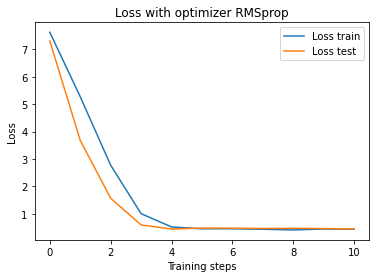

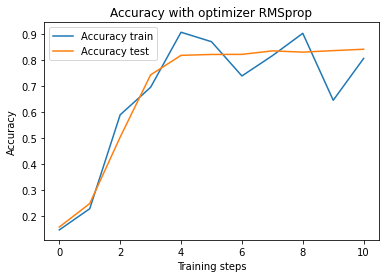

In [9]:
### Hyperparameters
num_epochs = 10
learning_rate = 0.001
    
# Initialize the optimizers: SGD, Adam, RMSprop
optimizers = [tf.keras.optimizers.SGD(learning_rate), tf.keras.optimizers.Adam(learning_rate), tf.keras.optimizers.RMSprop(learning_rate)]
opt_labels = ["SGD", "Adam", "RMSprop"]
count = 0

print("Choose Optimizer: SGD(1), Adam(2), RMSprop(3)")
x = int(input())

# set optimizer
opt = optimizers[x-1]

tf.keras.backend.clear_session()

# Initialize the model.
model = MyModel()
# Initialize the loss: categorical cross entropy. Check out 'tf.keras.losses'.
b_cross_entropy_loss = tf.keras.losses.BinaryCrossentropy()


# Initialize lists for later visualization.
train_losses = []
test_losses = []
val_losses = []

train_accuracies = []
test_accuracies = []
val_accuracies = []


#testing once before we begin
test_loss, test_accuracy = test(model, test_dataset, b_cross_entropy_loss)
test_losses.append(test_loss)
test_accuracies.append(test_accuracy)

#check how model performs on train data once before we begin
train_loss, train_accuracy = test(model, train_dataset, b_cross_entropy_loss)
train_losses.append(train_loss)
train_accuracies.append(train_accuracy)

#check how model performs on validate data once before we begin
val_loss, val_accuracy = test(model, val_dataset, b_cross_entropy_loss)
val_losses.append(val_loss)
val_accuracies.append(val_accuracy)


# We train for num_epochs epochs
for epoch in range(num_epochs):

    #training (and checking in with training)
    epoch_loss_agg = []
    epoch_acc_agg = []
    for input,target in train_dataset:
        train_loss, train_accuracy = train_step(model, input, target, b_cross_entropy_loss, opt)
        epoch_loss_agg.append(train_loss)

        #track training loss
    train_losses.append(tf.reduce_mean(epoch_loss_agg))
    # tracking train accuracy
    train_accuracies.append(tf.reduce_mean(train_accuracy))

    #testing, so we can track accuracy and test loss
    test_loss, test_accuracy = test(model, test_dataset, b_cross_entropy_loss)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)

    # validation
    val_loss, val_accuracy = validate(model, val_dataset, b_cross_entropy_loss)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    print(f' test_losses: {test_losses[-1]} , test_accuracies: {test_accuracies[-1]}')


# Visualization
# if validate = True plotting of validate data
plotting(train_losses, test_losses, val_losses, train_accuracies, test_accuracies, val_accuracies, opt_labels[x-1], validate = False)